In [7]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.2993, 0.7927, 0.0399],
        [0.5991, 0.2903, 0.0219],
        [0.3303, 0.9351, 0.8346],
        [0.0753, 0.0731, 0.6278],
        [0.6557, 0.8932, 0.4123]])


In [8]:
torch.cuda.is_available()

True

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [10]:
# Download training data from open datasets.

training_data = datasets.FashionMNIST(
  root = "data",
  train = True,
  download = True,
  transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
  root = 'data',
  train = False,
  download = True,
  transform = ToTensor()
)

In [11]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [12]:
batch_size = 65

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y : {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([65, 1, 28, 28])
Shape of y : torch.Size([65]) torch.int64


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss : {loss:>7f} [{current:>5d}/{size:>5d}]")

In [15]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error : \n Accuracy: {(100 * correct): > 0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t + 1}\n-------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)

print('Done')

Epoch 1
-------------------------
loss : 2.303112 [   65/60000]
loss : 2.297929 [ 6565/60000]
loss : 2.277251 [13065/60000]
loss : 2.265115 [19565/60000]
loss : 2.248604 [26065/60000]
loss : 2.241732 [32565/60000]
loss : 2.200700 [39065/60000]
loss : 2.189298 [45565/60000]
loss : 2.203624 [52065/60000]
loss : 2.177153 [58565/60000]
Test Error : 
 Accuracy:  49.4%, Avg loss: 2.165886 

Epoch 2
-------------------------
loss : 2.177180 [   65/60000]
loss : 2.154975 [ 6565/60000]
loss : 2.125274 [13065/60000]
loss : 2.097500 [19565/60000]
loss : 2.064606 [26065/60000]
loss : 2.064873 [32565/60000]
loss : 1.969805 [39065/60000]
loss : 1.944425 [45565/60000]
loss : 1.977931 [52065/60000]
loss : 1.929361 [58565/60000]
Test Error : 
 Accuracy:  54.8%, Avg loss: 1.910609 

Epoch 3
-------------------------
loss : 1.945406 [   65/60000]
loss : 1.883592 [ 6565/60000]
loss : 1.818695 [13065/60000]
loss : 1.780397 [19565/60000]
loss : 1.753278 [26065/60000]
loss : 1.732255 [32565/60000]
loss : 1.6

In [17]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [18]:
model = NeuralNetwork().to(device)

model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [19]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

model.eval()

x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f"Predicted: {predicted}, Actual: {actual}")

Predicted: Ankle boot, Actual: Ankle boot


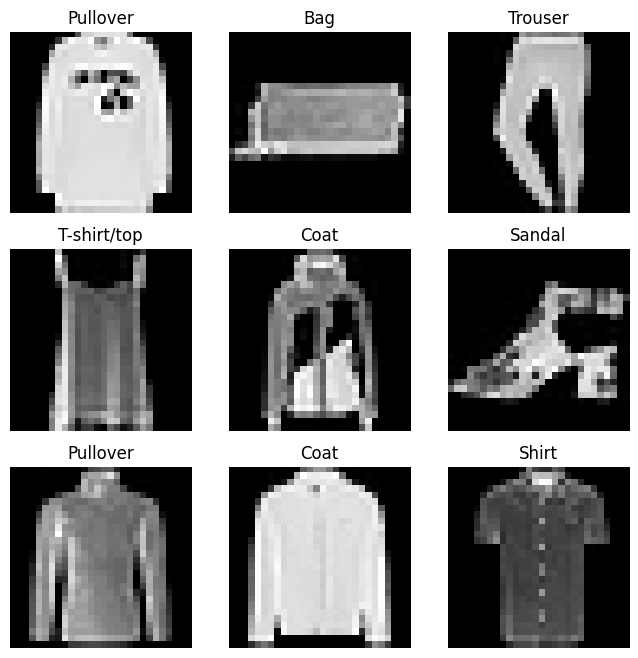